In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
import vector_tools as vt
import Functions as fn

#import matplotlib.patches as mpatches
from physoce import tseries as ts 
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy import stats
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from datetime import timedelta

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Spectral analysis and turbulent dissipation estimates

### Additional quality control for turbulent dissipation
- Additional QC of adv data is used to flag data runs (bursts of data) that have gaps of high correlation and signal strength (SNR)
- Parameters for dissipation QC are used from Fedderson, 2010 ("Quality controlling surf zone acoustic Doppler velocimeter observations to estimate the turbulent dissipation rate")
    - SNR on each beam should be > 15dB
    - CORR on each beam should be above .3 + .4(SQRT(f_s/f_max)), where f_s is the instrument sampling frequency, and f_max is the maximum sampling frequency the instrument is capable of 
    - Fraction of "bad data" to good data for each run is determined as sigmaSS and sigmaCORR
        - sigmaSS <= .1 (34560/38400 data points, or two minutes of "bad data" allowed)
        - sigmaCORR <= .7 (11520/38400 data points, or 14 minutes of "bad data" allowed)
    - Bad data runs that do not meet these criteria are discarded, and the remaining good data runs are "fixed"
        - Gaps in data <= 1s long are linearly interpolated between the good data points bounding the gap
        - Longer gaps are averaged and the entire gap is set to the averaged value
        - If the gap is significantly longer than a couple seconds, "patching" may be used
        - Patching removes the larger gaps in data and joins the good data points together, but may cause bias via time shifting in the frequency spectra

In [2]:
# Open up raw data (deployment and retreival data already removed)
adv1 = xr.open_dataset('ADV/adv1_dat.nc')
adv2 = xr.open_dataset('ADV/adv2_dat.nc')

In [4]:
snr_cutoff = 10 # 10 dB
corr_cutoff = .3 + (.4*np.sqrt(32/64)) # ~ 58% correlation
nmax = 38400 # Max number of samples in a single burst
fs = 32 # Sample frequency of the dataset

#e1_16hz = e_filter(adv1_16hz, SNR_cutoff, Corr_cutoff, , n_16, fs_16)
e1_qc = vt.eps_data_prep(adv1, snr_cutoff, corr_cutoff, nmax, fs)
e1_qc.to_netcdf('ADV/e1_qc.nc')

#e2_16hz = e_filter(adv2_16hz, SNR_cutoff, Corr_cutoff, n_16, fs_16)
e2_qc = vt.eps_data_prep(adv2, snr_cutoff, corr_cutoff, nmax, fs)
e2_qc.to_netcdf('ADV/e2_qc.nc')

Filtering low SNR data
Filtering low correlation data
Interpolating gaps < 1s
Sorting remaining gaps
Patching gaps > 10s
Averaging gaps between 1s and 10s
Filling in front and back gaps < 1s
Filtering low SNR data
Filtering low correlation data
Interpolating gaps < 1s
Sorting remaining gaps
Patching gaps > 10s
Averaging gaps between 1s and 10s
Filling in front and back gaps < 1s


### Spectral analysis
- With bad data points that fail SNR and Correlation cutoffs properly removed and interpolated, the remaining data needs to be "despiked"
- Velocity points that lie beyond an "expanded" Guassian threshold may be too large to be considered good data points
    - This despiking method is based on methodology from Wheeler and Giddings (2023)

In [5]:
# Import cleaned velocity data
e1 = xr.open_dataset('ADV/e1_qc.nc')
e2 = xr.open_dataset('ADV/e2_qc.nc')

In [6]:
temp = xr.open_dataset('Temperature/temp_w_rho.nc')

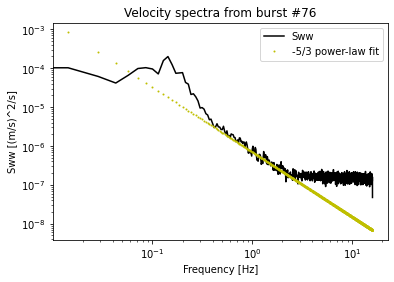

In [81]:
#burst_list = [76]
#rho = np.mean(temp.Rho.sel(time=slice(burst.time[0], burst.time[-1])))+1000 # Density
rho = np.mean(temp.Rho)+1000

Sw76, Sw76_pars, Sw76_cov = vt.eval_Sww(e1, 76, rho=rho, Spp_conv = False, Plot = True)

From Fedderson 2012

e = [(Pww(f) * 2(2pi)^(3/2)) / (a * Mww(f;ubar,sigma^2))]^(3/2)

- Pww(f) = vertical velocity times series from 70s long Hanning windowed data
- a = 1.4 (Kolmogoroff's constant)
- Mww = integral over 3D wavenumber space that transforms the inertial subrange k^-5/3 wavenumber dependence to a frequency average between 1.2 and 2 Hz

over 56 discrete frequencies
- ubar and sigma^2 = horizontal mean current and (wave dominated) three-component velocity variance

In [8]:
alpha = 1.4
Pww = Sw

### 3D Wavenumber space

In [135]:
def find_princaxs(ds,u,v):
    # THE FOLLOWING CODE IS ADAPTED FROM STEVEN CUNNINGHAM'S MASTERS THESIS (2019)

    # Rotate velocity data along the principle axes U and V
    theta, major, minor = ts.princax(u, v) # theta = angle, major = SD major axis (U), SD minor axis (V)
    U, V = ts.rot(u, v, -theta)
    ds['U'] = U
    ds['V'] = V
    
    return ds

e1 = find_princaxs(e1, e1.East, e1.North)

In [139]:
# Find J_lm using method from Gerbi et al. (2009)

# Select single "good" data burst
burst = e1.where(e1.Burst_number.isin(76), drop = True)
ds = burst.copy(deep=True) # Make a copy to not alter the original dataset

# Calculate mean current, standard deviation, and variance of velocity components
ubar = float(np.mean(ds.U))
vbar = float(np.mean(ds.V))
wbar = float(np.mean(ds.Vertical))
    
usig = float(np.std(ds.U)) # Standard deviation 
vsig = float(np.std(ds.V))
wsig = float(np.std(ds.Vertical))

uvar = float(np.std(ds.U)**2) # Variance
vvar = float(np.std(ds.V)**2)
wvar = float(np.std(ds.Vertical)**2)

# Create all values of theta, phi, and R within boundaries a to b
R = np.linspace(0, 6, 1000)
phi = np.linspace(0, 2*np.pi, 1000)
theta = np.linspace(0, np.pi, 1000)

fPhi_11 = np.empty((1000,1000))# Generate empty array for values of fPhi (dims = [Theta, Phi])
fPhi_22 = np.empty((1000,1000))
fPhi_33 = np.empty((1000,1000))

fTheta_11 = np.empty_like(theta) # Empty array to populate with values of fTheta (just 1d to be filled with integral of fPhi)
fTheta_22 = np.empty_like(theta)
fTheta_33 = np.empty_like(theta)

# R0, G, and P_lm are all functions of theta and phi, and can be pre-generated as 2d arrays before the nested loop
R0 = np.empty((1000,1000))
G = np.empty((1000,1000))
P_11 = np.empty((1000,1000))
P_22 = np.empty((1000,1000))
P_33 = np.empty((1000,1000))

for i in enumerate(theta): # Iterates through theta values (the rows of the empty 2d arrays)
    
    # Each row of the array is filled with the corresponding variable at all values of phi
    R0[i[0]] = ((ubar/usig) * (np.sin(i[1])*np.cos(phi))) + ((vbar/vsig) * (np.sin(i[1])*np.sin(phi)))
    G[i[0]] = np.sqrt((np.sin(i[1])**2)*(((np.cos(phi)**2)/uvar)+((np.sin(phi)**2)/vvar))+((np.cos(i[1])**2)/wvar))
    
    P_11[i[0]] = (1/(G[i[0]]**2))*((((np.sin(i[1])**2)*(np.sin(phi)**2))/vvar)+((np.cos(i[1])**2)/wvar))
    
    P_22[i[0]] = (1/(G[i[0]]**2))*((((np.sin(i[1])**2)*(np.cos(phi)**2))/uvar)+((np.cos(i[1])**2)/wvar))
    
    P_33[i[0]] = ((np.sin(i[1])**2)/(G[i[0]]**2))*(((np.cos(phi)**2)/uvar)+((np.sin(phi)**2)/vvar))
    
    # Loop resets and goes through all functions with theta[i+1]
    
# TRIPLE INTEGRAL LOOP

for i in enumerate(theta): # Iterates through theta values only after finding fR[a:b] and fPhi[a:b]
    
    for j in enumerate(phi): # Iterates through each value of phi
        
        # Calculate fR from a to b using pre-generated R0 values
        fR = (R**(2/3))*np.exp(-(((R0[i[0],j[0]]-R)**2)/2))
        
        # Populate empty fPhi array at the given space (theta[i], phi[i])
        fPhi_11[i[0],j[0]] = ((G[i[0],j[0]]**(-11/3))*np.sin(i[1])*P_11[i[0],j[0]] * np.trapz(fR, R)) # fPhi uses the integral of fR
        fPhi_22[i[0],j[0]] = ((G[i[0],j[0]]**(-11/3))*np.sin(i[1])*P_22[i[0],j[0]] * np.trapz(fR, R))
        fPhi_33[i[0],j[0]] = ((G[i[0],j[0]]**(-11/3))*np.sin(i[1])*P_33[i[0],j[0]] * np.trapz(fR, R))
        
        # Nested loop resets and goes through all functions with phi[i+1], but theta remains constant
    
    # Populate empty fTheta array with the integral of phi from phi[0] to phi[-1]
    fTheta_11[i[0]] = np.trapz(fPhi_11[i[0]], phi)
    fTheta_22[i[0]] = np.trapz(fPhi_22[i[0]], phi)
    fTheta_33[i[0]] = np.trapz(fPhi_33[i[0]], phi)
    
    # Loop resets and goes through all functions with theta[i+1]

# Evaluate the final integral of fTheta and use it to find J_lm    
J_11 = (1/(2*((2*np.pi)**(3/2))))*(1/(usig*vsig*wsig)) * np.trapz(fTheta_11, theta)
J_22 = (1/(2*((2*np.pi)**(3/2))))*(1/(usig*vsig*wsig)) * np.trapz(fTheta_22, theta)
J_33 = (1/(2*((2*np.pi)**(3/2))))*(1/(usig*vsig*wsig)) * np.trapz(fTheta_33, theta)

In [149]:
# Check if numerical solution of J_ll resembles analytical solution of M_ll
from scipy.special import gamma
gam = gamma(5/6)
sig0 = (usig + vsig + wsig)/3
M_ll = (sig0**(2/3))*gam*(2**(17/6))*np.pi

J_ll = (J_11+J_22+J_33)*(2*((2*np.pi)**(3/2)))

print('M_ll = ' + str(M_ll) + ' J_ll = ' + str(J_ll))

M_ll = 2.095789699757904 J_ll = 2.3072651280016756


In [192]:
sig0

0.02387818132827331

In [181]:
# Check value of M_ll using Fedderson et al. (2007)
# Equation A8 uses I(usig/vbar, pi/2)
# The fuction I itself is a single integral from inf to -inf, which can be evaluated using scipy.quad
I_x = usig/vbar
I_y = np.pi/2

def I_int(x):
    return (((x**2) - ((2/I_x)*np.cos(I_y)*x) + (1/I_x)**2)**(1/3)) * np.exp(-.5*(x**2))

from scipy import integrate
I, I_err = integrate.quad(I_int, -np.inf, np.inf)
I = I*(1/(2*np.pi))*((I_x**2)**(1/3))

In [182]:
I

1.2811906460219848

In [186]:
M_33 = (12/55)*(2*((2*(np.pi))**(3/2)))*((vbar**2)**(1/3))*I
M_33

0.2946209660371243

0.8335930140187576

In [177]:
test**(1/3)

3.8789330763481913